In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense, Dropout, LSTM
from keras.utils import to_categorical
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv').sort_values(['series_id', 'measurement_number'])

### Join train features with labels

In [3]:
train = pd.merge(train, labels, how='inner').sort_values(['series_id', 'measurement_number'])
print(train.shape)
display(train.head())
display(train.describe().T)

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700


### Turn data into series

In [4]:
def series_to_supervised(data, features, window=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data[features].shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in features]
    # Current timestep (t=0)
    cols.append(data)
    names += [(col) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [5]:
window = 5
features = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 
            'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 
            'series_id']
use_cols = features + ['surface']
# Train
train_series = series_to_supervised(train[use_cols], features, window=window)
train_series.dropna(inplace=True)        
train_series = train_series[(train_series['series_id'] == train_series['series_id(t-%s)' % window])]
display(train_series.head())

# Test
test_series = series_to_supervised(test[features], features, window=window)
test_series.fillna(test_series.mean(), inplace=True)
# Backwards inputation
for index, row in test_series.iterrows():
    for i in range(1, window+1):
        if row['series_id'] != row['series_id(t-%s)' % i]:
            for feature in features:
                if feature != 'series_id':
                    test_series.at[index, '%s(t-%s)' % (feature, i)] = row[feature]
display(test_series.head())

,orientation_X(t-5),orientation_Y(t-5),orientation_Z(t-5),orientation_W(t-5),angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),series_id(t-5),orientation_X(t-4),orientation_Y(t-4),orientation_Z(t-4),orientation_W(t-4),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),series_id(t-4),orientation_X(t-3),orientation_Y(t-3),orientation_Z(t-3),orientation_W(t-3),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),series_id(t-3),orientation_X(t-2),orientation_Y(t-2),orientation_Z(t-2),orientation_W(t-2),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),series_id(t-2),orientation_X(t-1),orientation_Y(t-1),orientation_Z(t-1),orientation_W(t-1),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),series_id(t-1),orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id,surface
5,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.0,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.50640,-9.4128,0.0,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.0,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.099300,-10.0960,0.0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0.0,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0,fine_concrete
6,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.0,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.0,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0.0,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.0,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0,fine_concrete
7,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,0.0,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.0,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.0,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.0,-0.75852,-0.63444,-0.10480,-0.10561,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0,fine_concrete
8,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,0.0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.0,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.44745,0.99281,-10.4020,0.0,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.0,-0.75852,-0.63444,-0.10480,-0.10561,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0.0,-0.75851,-0.63445,-0.10485,-0.10559,-0.012846,0.039004,-0.007831,1.60000,0.816110,-7.6426,0,fine_concrete
9,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.0,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.44745,0.99281,-10.4020,0.0,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.14163,0.73497,-9.4296,0.0,-0

,orientation_X(t-5),orientation_Y(t-5),orientation_Z(t-5),orientation_W(t-5),angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),series_id(t-5),orientation_X(t-4),orientation_Y(t-4),orientation_Z(t-4),orientation_W(t-4),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),series_id(t-4),orientation_X(t-3),orientation_Y(t-3),orientation_Z(t-3),orientation_W(t-3),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),series_id(t-3),orientation_X(t-2),orientation_Y(t-2),orientation_Z(t-2),orientation_W(t-2),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),series_id(t-2),orientation_X(t-1),orientation_Y(t-1),orientation_Z(t-1),orientation_W(t-1),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),series_id(t-1),orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id
0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.480474,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.484379,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.488284,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.49219,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.496095,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0
1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.480474,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.484379,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.488284,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.49219,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000000,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0
2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.480474,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.484379,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.488284,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.00000,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.000000,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0
3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,1907.480474,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,1907.484379,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000000,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.00000,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.000000,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,0
4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100,1907.480474,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000

### Pre process the labels

In [6]:
n_labels =  train_series['surface'].nunique()
labels_names = train_series['surface'].unique()
le = LabelEncoder()
train_series['surface'] = le.fit_transform(train_series['surface'].values)

### Train/validation split

In [7]:
X_train = train_series[train_series['series_id'] >= 1000]
X_val = train_series[train_series['series_id'] < 1000]

Y_train = X_train['surface']
Y_train = to_categorical(Y_train)
X_train.drop('surface', axis=1, inplace=True)
X_train = X_train

Y_val = X_val['surface']
Y_val = to_categorical(Y_val)
X_val.drop('surface', axis=1, inplace=True)
X_val = X_val

series_cols = list(X_train.filter(regex='series_id'))
X_train.drop(series_cols, axis=1, inplace=True)
X_val.drop(series_cols, axis=1, inplace=True)
test_series.drop(series_cols, axis=1, inplace=True)

print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.head())

Train shape (345630, 60)
Validation shape (123000, 60)


,orientation_X(t-5),orientation_Y(t-5),orientation_Z(t-5),orientation_W(t-5),angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),orientation_X(t-4),orientation_Y(t-4),orientation_Z(t-4),orientation_W(t-4),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),orientation_X(t-3),orientation_Y(t-3),orientation_Z(t-3),orientation_W(t-3),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),orientation_X(t-2),orientation_Y(t-2),orientation_Z(t-2),orientation_W(t-2),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),orientation_X(t-1),orientation_Y(t-1),orientation_Z(t-1),orientation_W(t-1),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
128005,-0.087888,-0.98485,-0.14940,-0.004722,0.009568,0.003490,-0.082588,0.30511,2.3174,-9.3569,-0.088108,-0.98485,-0.14929,-0.004764,0.043066,0.014478,-0.090635,-0.11657,2.1874,-9.2797,-0.087983,-0.98487,-0.14923,-0.004746,0.044569,0.025542,-0.097385,0.19611,2.3379,-8.8102,-0.087850,-0.98488,-0.14921,-0.004740,0.019559,0.018986,-0.105700,-0.15585,2.4070,-8.8009,-0.087721,-0.98490,-0.14921,-0.004752,0.002085,0.005758,-0.104080,-0.26070,2.2120,-9.5556,-0.087875,-0.98488,-0.14919,-0.004791,0.007471,0.023231,-0.108990,0.05065,1.9754,-10.3670
128006,-0.088108,-0.98485,-0.14929,-0.004764,0.043066,0.014478,-0.090635,-0.11657,2.1874,-9.2797,-0.087983,-0.98487,-0.14923,-0.004746,0.044569,0.025542,-0.097385,0.19611,2.3379,-8.8102,-0.087850,-0.98488,-0.14921,-0.004740,0.019559,0.018986,-0.105700,-0.15585,2.4070,-8.8009,-0.087721,-0.98490,-0.14921,-0.004752,0.002085,0.005758,-0.104080,-0.26070,2.2120,-9.5556,-0.087875,-0.98488,-0.14919,-0.004791,0.007471,0.023231,-0.108990,0.05065,1.9754,-10.3670,-0.087741,-0.98490,-0.14918,-0.004769,0.009717,0.032370,-0.103990,-0.43503,2.6366,-10.1270
128007,-0.087983,-0.98487,-0.14923,-0.004746,0.044569,0.025542,-0.097385,0.19611,2.3379,-8.8102,-0.087850,-0.98488,-0.14921,-0.004740,0.019559,0.018986,-0.105700,-0.15585,2.4070,-8.8009,-0.087721,-0.98490,-0.14921,-0.004752,0.002085,0.005758,-0.104080,-0.26070,2.2120,-9.5556,-0.087875,-0.98488,-0.14919,-0.004791,0.007471,0.023231,-0.108990,0.05065,1.9754,-10.3670,-0.087741,-0.98490,-0.14918,-0.004769,0.009717,0.032370,-0.103990,-0.43503,2.6366,-10.1270,-0.087625,-0.98491,-0.14914,-0.004760,0.030150,0.018235,-0.091317,-0.70057,2.5162,-10.1100
128008,-0.087850,-0.98488,-0.14921,-0.004740,0.019559,0.018986,-0.105700,-0.15585,2.4070,-8.8009,-0.087721,-0.98490,-0.14921,-0.004752,0.002085,0.005758,-0.104080,-0.26070,2.2120,-9.5556,-0.087875,-0.98488,-0.14919,-0.004791,0.007471,0.023231,-0.108990,0.05065,1.9754,-10.3670,-0.087741,-0.98490,-0.14918,-0.004769,0.009717,0.032370,-0.103990,-0.43503,2.6366,-10.1270,-0.087625,-0.98491,-0.14914,-0.004760,0.030150,0.018235,-0.091317,-0.70057,2.5162,-10.1100,-0.087509,-0.98493,-0.14908,-0.004758,0.048970,0.011908,-0.093001,-0.45737,1.7783,-10.5750
128009,-0.087721,-0.98490,-0.14921,-0.004752,0.002085,0.005758,-0.104080,-0.26070,2.2120,-9.5556,-0.087875,-0.98488,-0.14919,-0.004791,0.007471,0.023231,-0.108990,0.05065,1.9754,-10.3670,-0.087741,-0.98490,-0.14918,-0.004769,0.009717,0.032370,-0.103990,-0.43503,2.6366,-10.1270,-0.087625,-0.98491,-0.14914,-0.004760,0.030150,0.018235,-0.091317,-0.70057,2.5162,-10.1100,-0.087509,-0.98493,-0.14908,-0.004758,0.048970,0.011908,-0.093001,-0.45737,1.7783,-10.5750,-0.087620,-0.98492,-0.149

### Feature engineering

In [8]:
features = list(X_train.columns)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.describe().T)

Train shape (345630, 60)
Validation shape (123000, 60)


,count,mean,std,min,25%,50%,75%,max
orientation_X(t-5),345630.0,-0.029367,0.686206,-0.98910,-0.709387,-0.169360,0.648647,0.98891
orientation_Y(t-5),345630.0,0.148739,0.695665,-0.98965,-0.612537,0.364430,0.849587,0.98898
orientation_Z(t-5),345630.0,0.023967,0.103575,-0.15344,-0.082509,0.057525,0.128770,0.15566
orientation_W(t-5),345630.0,-0.006295,0.104144,-0.15662,-0.107940,-0.029485,0.092856,0.15477
angular_velocity_X(t-5),345630.0,0.000069,0.124114,-2.37100,-0.042976,-0.000057,0.042085,2.28220
angular_velocity_Y(t-5),345630.0,0.008033,0.094100,-0.92786,-0.036760,0.004913,0.050654,0.83621
angular_velocity_Z(t-5),345630.0,-0.017914,0.247295,-1.26880,-0.095630,-0.005034,0.070409,1.38730
linear_acceleration_X(t-5),345630.0,0.127874,1.950448,-36.06700,-0.561010,0.127775,0.819490,36.79700
linear_acceleration_Y(t-5),345630.0,2.875454,2.184200,-121.49000,1.931325,2.864300,3.803600,73.00800
linear_acceleration_Z(t-5),345630.0,-9.367321,3.007669,-75.38600,-10.249000,-9.371600,-8.473125,65.83900


### Scale the data

In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_series)

In [10]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_series = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_val_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (345630, 60, 1)
Validation set shape (123000, 60, 1)
Test set shape (488448, 60, 1)


### Model

In [11]:
epochs = 12
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model = Sequential()
model.add(LSTM(60, activation='relu', return_sequences=True, input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model.add(LSTM(30, activation='relu'))
model.add(Dense(n_labels, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 60)            14880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                10920     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 279       
Total params: 26,079
Trainable params: 26,079
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train_series, Y_train, validation_data=(X_val_series, Y_val), epochs=epochs, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 345630 samples, validate on 123000 samples
Epoch 1/12
 - 1870s - loss: 1.5999 - val_loss: 1.9990
Epoch 2/12
 - 1823s - loss: 1.5246 - val_loss: 2.2322
Epoch 3/12
 - 1834s - loss: 1.5600 - val_loss: 1.9689
Epoch 4/12
 - 1861s - loss: 1.3570 - val_loss: 2.0330
Epoch 5/12
 - 1861s - loss: 1.1997 - val_loss: 1.5806
Epoch 6/12
 - 1848s - loss: 1.0541 - val_loss: 1.5042
Epoch 7/12
 - 1808s - loss: 1.0857 - val_loss: 1.9085
Epoch 8/12
 - 1817s - loss: 1.1352 - val_loss: 1.6694
Epoch 9/12
 - 1815s - loss: 14.0856 - val_loss: 14.8842
Epoch 10/12
 - 1820s - loss: 14.3914 - val_loss: 14.8842
Epoch 11/12
 - 1820s - loss: 14.3914 - val_loss: 14.8842
Epoch 12/12
 - 1819s - loss: 14.3914 - val_loss: 14.8842


#### Model loss plot

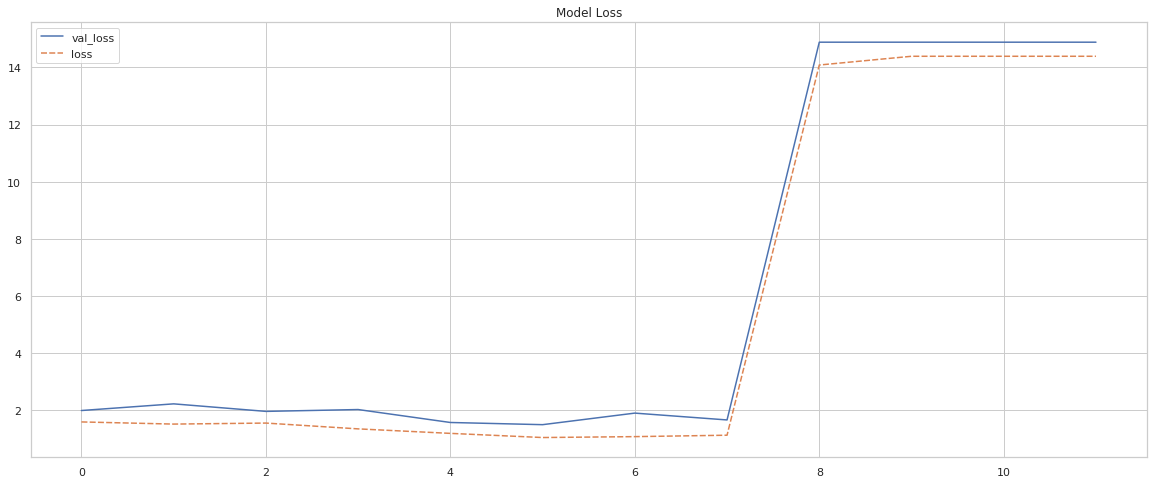

In [14]:
history_pd = pd.DataFrame.from_dict(history.history)
plt.figure(figsize=(20, 8))
ax = plt.axes()
ax.set_title('Model Loss')
sns.lineplot(data=history_pd)
plt.show()

#### Model evaluation

In [15]:
train_pred = model.predict_classes(X_train_series)
val_pred = model.predict_classes(X_val_series)
Y_train_max = np.argmax(Y_train, axis=1)
Y_val_max = np.argmax(Y_val, axis=1)

print('Train accuracy', accuracy_score(Y_train_max, train_pred))
print('Validation accuracy', accuracy_score(Y_val_max, val_pred))

Train accuracy 0.10712901079188727
Validation accuracy 0.07655284552845529


#### Model confusion matrix

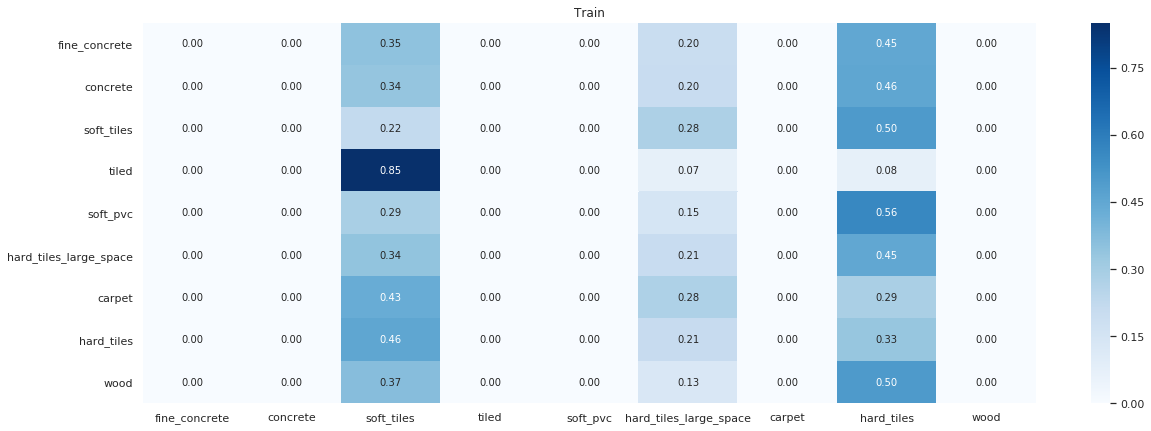

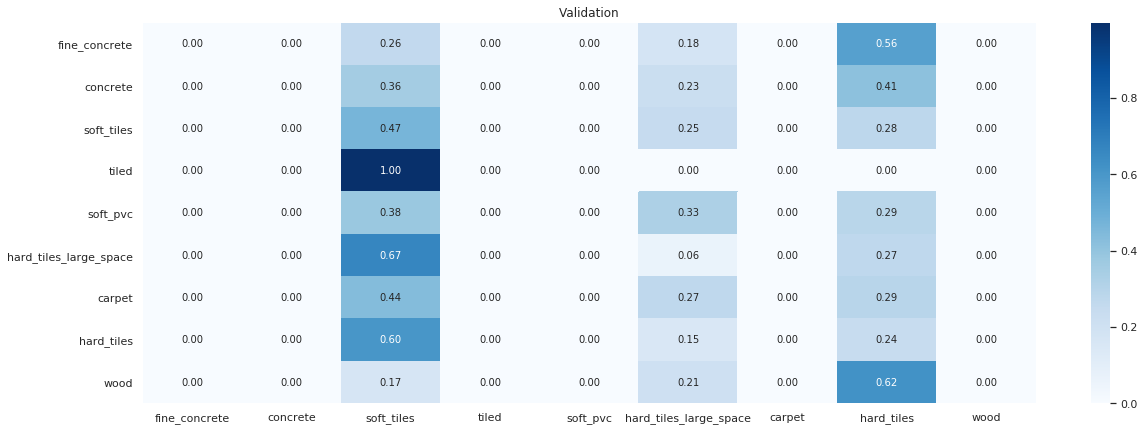

In [16]:
cnf_matrix = confusion_matrix(Y_train_max, train_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(Y_val_max, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [ ]:
predictions = model.predict_classes(X_test_series)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)